In [24]:
#This module calculates the physicochemical properties for lytic and non-lytic proteins 
#requires fasta files for both lytic and non-lytic protein sequences 
#requires running this script seperately for both the lytic and non-lytic files

# Import parts of Biopython
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from plotly import express 
import plotly.graph_objects as go

fastafile = ".../example.fasta"

aminoacids = ['A', 'G', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']

with open(fastafile, mode='r') as handle: 
    outputbinaryfile = open('.../examplefile.pkl', 'wb')

    protein_dict = {}
    #parse fasta using biopython
    for record in SeqIO.parse(handle, 'fasta'):
        seq = str(record.seq)
        newseq = ''.join([i for i in seq if i in aminoacids])
        protein = ProteinAnalysis(newseq)

        descriptors = (ProteinAnalysis.count_amino_acids,
                       ProteinAnalysis.get_amino_acids_percent,
                       ProteinAnalysis.molecular_weight,
                       ProteinAnalysis.instability_index,
                       ProteinAnalysis.isoelectric_point,
                       ProteinAnalysis.secondary_structure_fraction,
                       ProteinAnalysis.aromaticity, 
                       ProteinAnalysis.gravy, 
                       ProteinAnalysis.molar_extinction_coefficient,  
                       ProteinAnalysis.flexibility)
        descriptor_dict = {method.__name__: method(protein) for method in descriptors}
        protein_dict[record.id] = descriptor_dict
    
pickle.dump(protein_dict, outputbinaryfile)
outputbinaryfile.close()

In [10]:
#this part of code loads the previously created pickled dicts to enable 3D graph drawing 

picklefile = '.../examplefile.pkl'
def loadProteins(filename):
    pkl_file = open(filename, 'rb')
    proteins = pickle.load(pkl_file)
    pkl_file.close()
    return proteins

dict = loadProteins(picklefile)

In [19]:
#this part of code deals with the values of the dictionaries which are not a single item, for example a dict or list 
#do this module for each dict seperately 

def CleanDict(dict):
    for key, value in dict.items():
        for item, val in enumerate(sw['secondary_structure_fraction']):
            value[f'secondary_structure_fraction.{i}'] = val
        del value['secondary_structure_fraction']
        for item, val in enumerate(sw['molar_extinction_coefficient']):
            value[f'molar_extinction_coefficient.{i}'] = val
        del value['molar_extinction_coefficient']
    return dict 


In [20]:
# In this module select random sample from all three file types (posenzy, posuni, neguni)

def GetDataframe(posenzydict, posunidict, negunidict):      
    dfpos =pd.DataFrame.from_dict(posunidict,orient='index').rename_axis('name').reset_index()
    dfneg =pd.DataFrame.from_dict(negunidict,orient='index').rename_axis('name').reset_index()
    dfenzy =pd.DataFrame.from_dict(posenzydict,orient='index').rename_axis('name').reset_index()
    #adds a color column in each dataframe (needed for the 3D plot)
    dfpos['color'] = 'posuni'
    dfneg['color'] = 'neguni'
    dfenzy['color'] = 'posenzy'
    #add also the protein status (not needed for the 3D plot, but the correlation matrix)
    dfpos['status'] = 1
    dfneg['status'] = 0
    dfenzy['status'] = 2   

    totallist = [dfpos, dfneg, dfenzy]
    totaldf = pd.concat(totallist)
    posit = dfpos.sample(n= 100, random_state = 10)
    negit = dfneg.sample(n = 200, random_state =11)
    enzyit = dfenzy.sample(n = 100, random_state = 12)
    mylist = [posit, negit, enzyit]
    total = pd.concat(mylist)
    return total

In [22]:
#this code enables drawing a 3D graph of the proteins. Each dot represents one protein with the values of a given physiochemical
#trait and laid out in a 3D space. Select the properties 

total['size'] = 10
color_discrete_map = {'neg': 'rgb(0,0, 255)', 'pos': 'rgb(255, 0, 128)', 'enzy': 'rgb(0,255,0)'}


fig = express.scatter_3d(total,
                         x='physical_property_1', y='physical_property_2', z='physical_property_3',
                         color='color',
                         size='size',
                         size_max=20,
                         hover_name='name',
                         hover_data=['physical_property_1', 
                                     'physical_property_2', 
                                     'physical_property_3'],
                         color_discrete_map=color_discrete_map)
fig.update_traces(marker=dict(size=2))
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.write_html("examplefile.html")
fig.show()

In [56]:
#Calculate correlation
import seaborn as sns
pearson = total.corr(method = 'pearson')
spearman = total.corr(method = 'spearman')
kendall = total.corr(method = 'kendall')

pearson.style.background_gradient(cmap='coolwarm')

C:\Users\sophi\anaconda3\lib\site-packages\pandas\io\formats\style.py:1126: RuntimeWarning:

All-NaN slice encountered

C:\Users\sophi\anaconda3\lib\site-packages\pandas\io\formats\style.py:1127: RuntimeWarning:

All-NaN slice encountered



<AxesSubplot:>

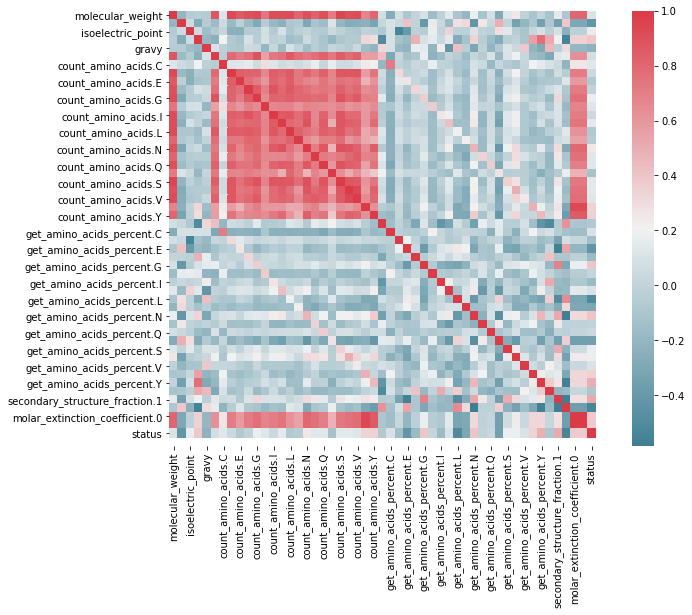

In [57]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pearson, mask=np.zeros_like(pearson, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [23]:
#Make the heatmap smaller, so make the df smaller 
correlationdf = totaldf[['molecular_weight', 'isoelectric_point', 'gravy', 'secondary_structure_fraction.0', 'secondary_structure_fraction.1', 'secondary_structure_fraction.2', 'aromaticity', 'instability_index', 'molar_extinction_coefficient.0', 'molar_extinction_coefficient.1', 'status']]
import seaborn as sns
pearson = correlationdf.corr(method = 'pearson')
spearman = correlationdf.corr(method = 'spearman')
kendall = correlationdf.corr(method = 'kendall')

pearson.style.background_gradient(cmap='coolwarm')
#fig2 = spearman.style.background_gradient(cmap='coolwarm')
#fig3 = kendall.style.background_gradient(cmap='coolwarm')

,molecular_weight,isoelectric_point,gravy,secondary_structure_fraction.0,secondary_structure_fraction.1,secondary_structure_fraction.2,aromaticity,instability_index,molar_extinction_coefficient.0,molar_extinction_coefficient.1,status
molecular_weight,1.000000,-0.019487,-0.115305,-0.124938,0.166708,-0.142793,0.031726,-0.184929,0.815336,0.815321,0.116334
isoelectric_point,-0.019487,1.000000,-0.107613,-0.044161,0.005076,-0.180800,-0.031809,0.057466,0.011831,0.012056,0.109935
gravy,-0.115305,-0.107613,1.000000,0.563625,-0.054054,0.392698,-0.202582,-0.114179,-0.238943,-0.238996,-0.269252
secondary_structure_fraction.0,-0.124938,-0.044161,0.563625,1.000000,-0.221584,-0.065131,0.435768,-0.148167,-0.005329,-0.005324,-0.018744
secondary_structure_fraction.1,0.166708,0.005076,-0.054054,-0.221584,1.000000,-0.559395,0.185488,-0.310182,0.282391,0.282185,0.490551
secondary_structure_fraction.2,-0.142793,-0.180800,0.392698,-0.065131,-0.559395,1.000000,-0.591234,0.376422,-0.404632,-0.404888,-0.603853
aromaticity,0.031726,-0.031809,-0.202582,0.435768,0.185488,-0.591234,1.000000,-0.291505,0.419055,0.419098,0.529983
instability_index,-0.184929,0.057466,-0.114179,-0.148167,-0.310182,0.376422,-0.291505,1.000000,-0.277813,-0.277329,-0.449346
molar_extinction_coefficient.0,0.815336,0.011831,-0.238943,-0.005329,0.282391,-0.404632,0.419055,-0.277813,1.000000,0.999994,0.446389
molar_extinction_coefficient.1,0.815321,0.012056,-0.238996,-0.005324,0.282185,-0.404888,0.419098,-0.277329,0.999994,1.000000,0.446304


In [24]:
import plotly.express as px

pearson.style.background_gradient(cmap='coolwarm').to_excel(r"C:\Users\sophi\Dropbox\Biology_phd\SeleniumScraping\pearson_shortUniNEnzy.xlsx", engine='openpyxl')


In [1]:
# Import parts of Biopython
from Bio import SeqIO
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import pandas as pd
import pickle
# File path to your FASTA file and map the proteins to your fasta file 
path_to_file_pb = r"C:\Users\sophi\Desktop\wyniki2021_reworked\culling_results\denovo_synthesis_prots\negUni21072022.fasta"   # <--- substitute by your local path

In [2]:
aminoacids = ['A', 'G', 'L', 'M', 'F', 'W', 'K', 'Q', 'E', 'S', 'P', 'V', 'I', 'C', 'Y', 'H', 'R', 'N', 'D', 'T']
with open(path_to_file_pb, mode='r') as handle:
    positivefile = open(r"C:\Users\sophi\Desktop\wyniki2021_reworked\culling_results\denovo_synthesis_prots\negUni21072022biosequtils.pkl", 'wb')
    
    positive_dict = {}
       
    for record in SeqIO.parse(handle, 'fasta'):
        seq = str(record.seq)
        newseq = ''.join([i for i in seq if i in aminoacids])
        protein = ProteinAnalysis(newseq)

        descriptors = (ProteinAnalysis.count_amino_acids,
                       ProteinAnalysis.get_amino_acids_percent,
                       ProteinAnalysis.molecular_weight,
                       ProteinAnalysis.instability_index,
                       ProteinAnalysis.isoelectric_point,
                       ProteinAnalysis.secondary_structure_fraction,
                       ProteinAnalysis.aromaticity, 
                       ProteinAnalysis.gravy, 
                       ProteinAnalysis.molar_extinction_coefficient,  
                       ProteinAnalysis.flexibility)
        descriptor_dict = {method.__name__: method(protein) for method in descriptors}
        positive_dict[record.id] = descriptor_dict
pickle.dump(positive_dict, positivefile)
positivefile.close()

In [5]:
filename = r"C:\Users\sophi\Desktop\wyniki2021_reworked\culling_results\denovo_synthesis_prots\negUni21072022biosequtils.pkl"
def loadProteins(filename):
    pkl_file = open(filename, 'rb')
    proteins = pickle.load(pkl_file)
    pkl_file.close()
    return proteins

prots = loadProteins(filename)

In [13]:
outputwrite = open(r"C:\Users\sophi\Desktop\wyniki2021_reworked\culling_results\denovo_synthesis_prots\negUni21072022ssfi.txt", 'a+')
for p, val in prots.items():
    line = p+'\t'+str(val['secondary_structure_fraction'][1])+'\t'+str(val['secondary_structure_fraction'][2])+'\t'+str(val['aromaticity'])+'\t'+str(val['instability_index'])+'\n'
    outputwrite.write(line)
outputwrite.close()

In [ ]:
#use this module to generate 